# Simple Speech Recognition v2
### From the tensorflow tutorial: https://www.tensorflow.org/tutorials/audio/simple_audio

In [1]:
import os
import logging

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

2024-05-04 16:59:17.167861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Seed the RNG and download data if there is none.

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

DATASET_PATH = 'data/mini_with_numbers'
data_dir = pathlib.Path(DATASET_PATH)

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['right' 'eight' 'go' 'no' 'nine' 'left' 'stop' 'three' 'one' 'zero'
 'seven' 'up' 'two' 'down' 'six' 'yes' 'five' 'four']


## Split the data in training and validation sets.

In [4]:
# <= 1 seconds audio clips at 16KHz
# output_sequence_length pads and trims to 1 second to be easily batched.
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=data_dir,
        batch_size=64,
        validation_split=0.2,
        seed=0,
        output_sequence_length=16000,
        subset='both')

label_names = np.array(train_ds.class_names)
print('\nlabel names:', label_names)

Found 69864 files belonging to 18 classes.
Using 55892 files for training.
Using 13972 files for validation.

label names: ['down' 'eight' 'five' 'four' 'go' 'left' 'nine' 'no' 'one' 'right'
 'seven' 'six' 'stop' 'three' 'two' 'up' 'yes' 'zero']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
# only single channel audio, so use tf.squeeze to drop the extra axis
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

## Split off a test set from the validation data.

In [7]:
# split off a test set from the validation set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

for example_audio, example_labels in train_ds.take(1):
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


2024-05-04 16:59:22.118761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [55892]
	 [[{{node Placeholder/_0}}]]
2024-05-04 16:59:22.119131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [55892]
	 [[{{node Placeholder/_4}}]]


## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

In [8]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)

    # Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)

    # Add a 'channels' dimension, so that the spectrogram can be used as an
    # image-like input data w/ convolution layers, which expect shape
    # (batch_size, height, width, channels)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

### Create Spectrogram Datasets

In [9]:
def make_spec_ds(ds):
    return ds.map(map_func=lambda audio, label: (get_spectrogram(audio), label),
                  num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

### Build and Train the Model

In [11]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

## Use a CNN since the audio files have been transformed into spectrogram images
### The tf.kera.Sequenctial will use the preprocessing layers:
- layers.Resizing to downsample to input to enable the model to train faster.
- layers.Normalization to normalize each pixel in the image based on it's mean and std

In [12]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

num_labels = len(label_names)

# Instantiate the normalization layer
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrogram
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input
    layers.Resizing(64, 64),
    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

2024-05-04 16:59:22.526514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [55892]
	 [[{{node Placeholder/_4}}]]
2024-05-04 16:59:22.526946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [55892]
	 [[{{node Placeholder/_4}}]]
2024-05-04 16:59:32.574490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 342 of 10000
2024-05-04 16:59:42.557409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 701 of 10000
2024-05-04 1

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling 

### Taking a look at the norm layer

In [13]:
norm_layer.mean.numpy(), norm_layer.variance.numpy(), norm_layer.count.numpy()

(array([[[[0.13709614]]]], dtype=float32),
 array([[[[0.66497695]]]], dtype=float32),
 894048432)

### Configure the Keras model w/ the Adam optimizer and the cross-entropy loss

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model over 10 epochs for demonstation purposes.

In [15]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


2024-05-04 16:59:49.290256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [55892]
	 [[{{node Placeholder/_0}}]]
2024-05-04 16:59:49.290799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [55892]
	 [[{{node Placeholder/_4}}]]


874/874 [==============================] - ETA: 0s - loss: 1.3418 - accuracy: 0.5877

2024-05-04 17:01:18.253589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13972]
	 [[{{node Placeholder/_0}}]]
2024-05-04 17:01:18.253898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13972]
	 [[{{node Placeholder/_4}}]]


874/874 [==============================] - 95s 108ms/step - loss: 1.3418 - accuracy: 0.5877 - val_loss: 0.4784 - val_accuracy: 0.8614
Epoch 2/20
874/874 [==============================] - 90s 103ms/step - loss: 0.5907 - accuracy: 0.8204 - val_loss: 0.3442 - val_accuracy: 0.8969
Epoch 3/20
874/874 [==============================] - 90s 103ms/step - loss: 0.4410 - accuracy: 0.8653 - val_loss: 0.2753 - val_accuracy: 0.9167
Epoch 4/20
874/874 [==============================] - 90s 103ms/step - loss: 0.3692 - accuracy: 0.8862 - val_loss: 0.2755 - val_accuracy: 0.9196
Epoch 5/20
874/874 [==============================] - 90s 103ms/step - loss: 0.3269 - accuracy: 0.8976 - val_loss: 0.2410 - val_accuracy: 0.9283
Epoch 6/20
874/874 [==============================] - 90s 103ms/step - loss: 0.2921 - accuracy: 0.9083 - val_loss: 0.2421 - val_accuracy: 0.9283
Epoch 7/20
874/874 [==============================] - 91s 104ms/step - loss: 0.2664 - accuracy: 0.9174 - val_loss: 0.2295 - val_accuracy: 0.9

### Plot the training and validation loss curves

Text(0, 0.5, 'Accuracy [%]')

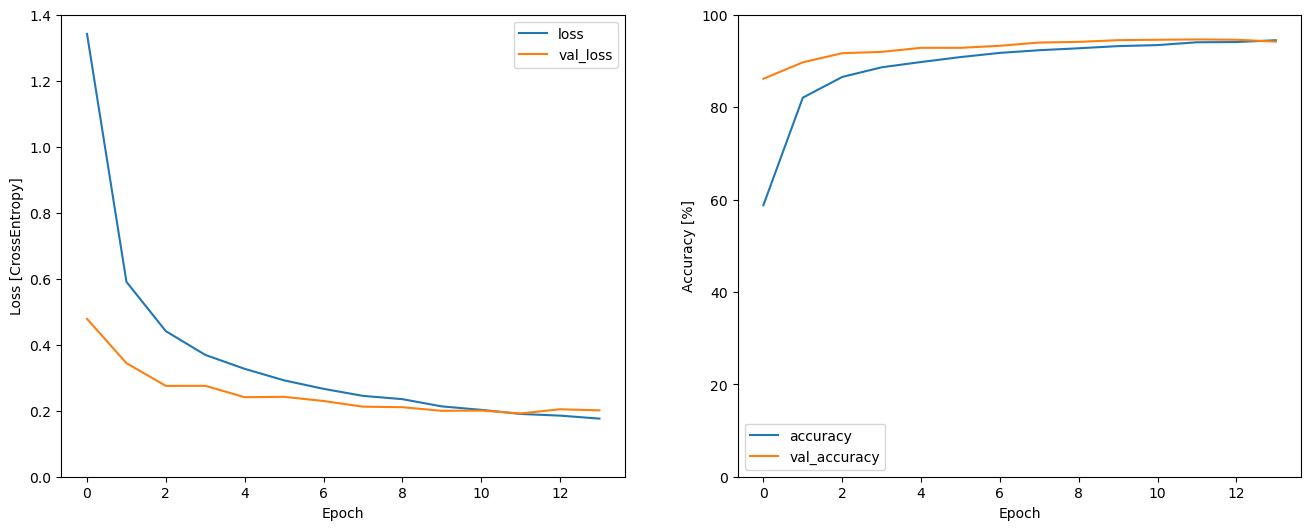

In [16]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model on the test set

In [17]:
model.evaluate(test_spectrogram_ds, return_dict=True)

2024-05-04 17:21:02.413377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13972]
	 [[{{node Placeholder/_0}}]]
2024-05-04 17:21:02.413687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13972]
	 [[{{node Placeholder/_4}}]]


110/110 [==============================] - 7s 61ms/step - loss: 0.1900 - accuracy: 0.9441


{'loss': 0.19001196324825287, 'accuracy': 0.9441109299659729}

### Display a confusion matrix

In [18]:
y_pred = model.predict(test_spectrogram_ds)

110/110 [==============================] - 3s 29ms/step


In [19]:
y_pred = tf.argmax(y_pred, axis=1)

In [20]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

2024-05-04 17:21:12.710705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13972]
	 [[{{node Placeholder/_4}}]]
2024-05-04 17:21:12.711497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [13972]
	 [[{{node Placeholder/_4}}]]


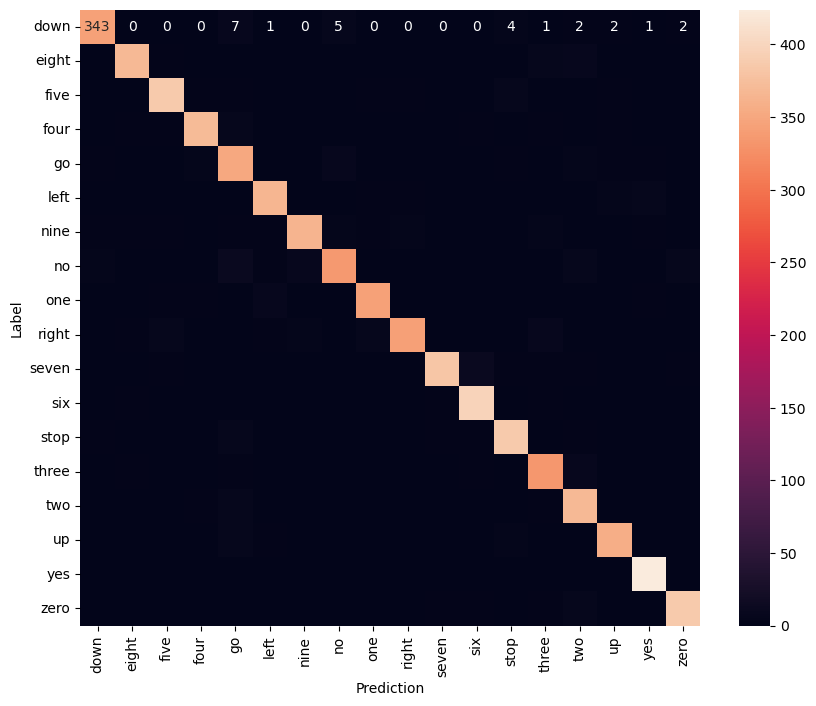

In [21]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Export the model w/ preprocessing

In [22]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model
        
        # string filename
        self.__call__.get_concrete_function(x=tf.TensorSpec(shape=(), dtype=tf.string))

        # batch of waveforms
        self.__call__.get_concrete_function(x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

    @tf.function
    def __call__(self, x):
        # if string filename, load the file and decode it
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions': result,
                'class_ids': class_ids,
                'class_names': class_names}

### Run the export model

In [23]:
export = ExportModel(model)
res = export(tf.constant(str(data_dir/'../yes.wav')))
label = label_names[res['predictions'].numpy().argmax()]
print('Prediction:', label)

Prediction: yes


### Save and reload the model

In [24]:
tf.saved_model.save(export, 'saved_mini_with_numbers')
imported = tf.saved_model.load('saved_mini_with_numbers')

2024-05-04 17:21:14.173554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,6,128]
	 [[{{node inputs}}]]
2024-05-04 17:21:14.193922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2024-05-04 17:21:14.494169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6,6,128]
	 [[{{node inputs}}]]
2024-05-

INFO:tensorflow:Assets written to: saved_mini_with_numbers/assets


INFO:tensorflow:Assets written to: saved_mini_with_numbers/assets


In [25]:
def get_waveform(wavfile):
    x = tf.io.read_file(str(wavfile))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
    return tf.squeeze(x, axis=-1)

In [26]:
#waveform = get_waveform(data_dir/'../yes.wav')
waveform = get_waveform('/Users/drank/dev/ml/audio/simple-sr/tools/test-16.wav')
m = imported(waveform[tf.newaxis, :])
z = zip(label_names, m['predictions'].numpy()[0])
z = [x for x in z]

res = sorted(z, key=lambda x: x[1], reverse=True) 
label = label_names[m['predictions'].numpy().argmax()]

for r in res:
    print(r)
print('Prediction:', label)

('yes', 10.644114)
('six', -1.2344902)
('left', -2.3191342)
('zero', -2.9374099)
('go', -3.035251)
('two', -3.3435931)
('stop', -4.606053)
('four', -5.126477)
('eight', -5.4230585)
('seven', -5.534938)
('no', -5.5767064)
('one', -7.7293243)
('down', -7.8283467)
('up', -8.428621)
('right', -8.852313)
('three', -9.351572)
('five', -15.984757)
('nine', -16.149652)
Prediction: yes


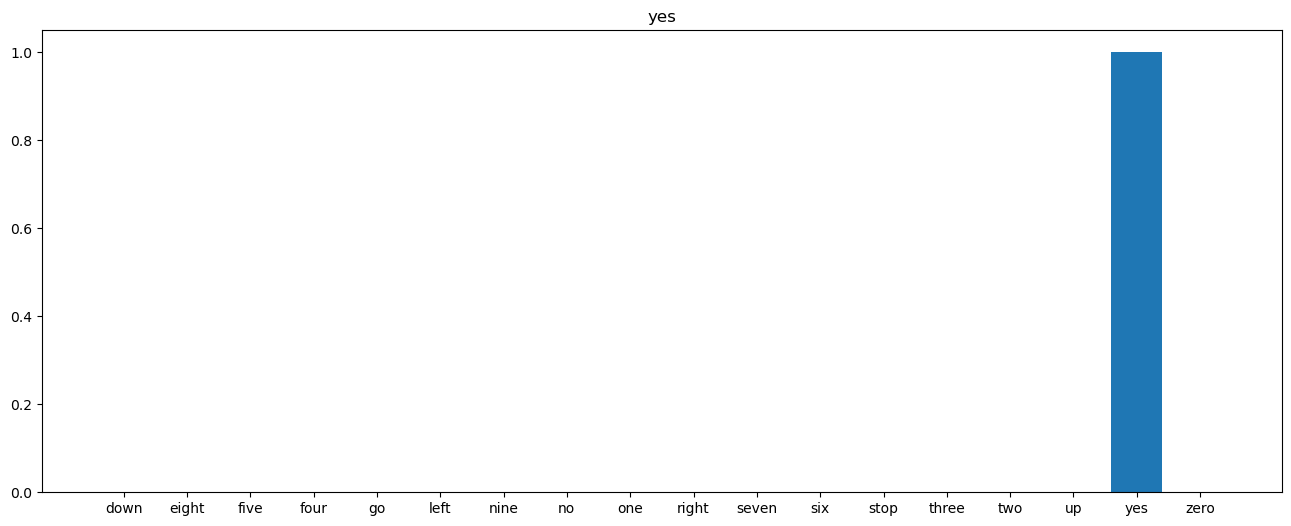

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [32]:
plt.figure(figsize=(16,6))
plt.bar(label_names, tf.nn.softmax(m['predictions'][0]))
plt.title(label)
plt.show()

spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

### Save the model as HDF5

In [28]:
model.save('simple-sr_mini_with_numbers.h5', save_format='h5')

### Load the HDF5 model

In [29]:
h5_model = tf.keras.models.load_model('simple-sr_mini_with_numbers.h5')
h5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0

### Test the HDF5 model

In [30]:
input_data = get_spectrogram(waveform)
input_data = input_data[tf.newaxis,...]
result = h5_model(input_data, training=False)
label = label_names[m['predictions'].numpy().argmax()]
print('Prediction:', label)
result

Prediction: yes


<tf.Tensor: shape=(1, 18), dtype=float32, numpy=
array([[ -7.8283467,  -5.4230585, -15.984757 ,  -5.126477 ,  -3.035251 ,
         -2.3191342, -16.149652 ,  -5.5767064,  -7.7293243,  -8.852313 ,
         -5.534938 ,  -1.2344902,  -4.606053 ,  -9.351572 ,  -3.3435931,
         -8.428621 ,  10.644114 ,  -2.9374099]], dtype=float32)>